In [1]:
!echo $PATH

/Users/benjamin/anaconda3/envs/RIP/bin:/Users/benjamin/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin


In [80]:
%matplotlib inline
import pandas as pd
import os
import re
from pybedtools import BedTool
import numpy as np
import pybedtools
import re
import matplotlib.pyplot as plt
import json
import matplotlib
import subprocess
import numpy as np
import shutil
import seaborn as sns
import scipy.stats
import statsmodels.stats.multitest

In [3]:
#define your input folders
#define your input folders updated for haplotigs
EFFECTORP_FOLDER = '../../../genome_v03/annotation/functional/'
BUSCO_FOLDER = '../../../genome_v03/annotation/BUSCO/'
GFF_FOLDER = '../../../genome_v03/annotation/structural/'
GENOME_FOLDER = '../../genome/'
TE_FOLDER = '../../TE_analysis/'
EFFECTOR_FOLDER = '../../../genome_v03/effector_analysis'
PROTEIN_ANNO_FOLDER = '../../annotation/functional/'
AT_analysis = '../../AT_analysis'
OUT_FOLDER = os.path.join(AT_analysis, 'Dinucl')
TMP_FOLDER = os.path.join(OUT_FOLDER, 'difacount')
CONTROL_FOLDER = os.path.join(AT_analysis, 'control_samples')
OUT_FOLDER_FIG = '../../figures/'
TMP_FIG_PATH = '../../../genome_v03/tmp_figures'
genome = 'APSI_primary_v1'
REPET_genome = 'MR_P2_a0'

In [4]:
if not os.path.exists(OUT_FOLDER):
    os.mkdir(OUT_FOLDER)

In [5]:
if not os.path.exists(TMP_FOLDER):
    os.mkdir(TMP_FOLDER)

In [6]:
#now get all the file names
genome_fn = os.path.join(GENOME_FOLDER, '%s.fa' %genome)
test_fn = os.path.join(TMP_FOLDER, 'test.fa')
!head {genome_fn} > {test_fn}

In [ ]:
!head {test_fn}

In [7]:
def facount(in_fn, out_fn):
    cmd = 'faCount -dinuc %s > %s' % \
    (os.path.abspath(in_fn), os.path.abspath(out_fn))
    output = subprocess.run(cmd, shell=True)
    return output.returncode

In [8]:
def do_RIP_call(fac_fn):
    "Return pandas dataframe with caculations reading in the faCount outfile."
    faC_header = ['seqID','len','A','C','G','T','N','cpg','AA','AC','AG',
                 'AT','CA','CC','CG','CT','GA','GC','GG','GT','TA','TC','TG','TT']
    count_dict = {}
    for n_pattern in faC_header:
        count_dict[n_pattern] = []
    dtypes = {}
    for x in faC_header:
        dtypes[x] = 'int'
    dtypes['seqID'] = 'str'
    with open(fac_fn) as fh: 
        for line in fh:
            line = line.rstrip()
            split_line = re.split('\t', line)
            if not line.startswith('#'):
                #if len(split_line) > len(faC_header):
                  #  split_line = split_line[0:len(faC_header)+1]

                for n_pattern, value in zip(faC_header, split_line):
                    count_dict[n_pattern].append(value)
    df = pd.DataFrame.from_dict(count_dict)
    df = df.astype(dtypes)
    df['TpA/ApT'] = df['TA']/df['AT']
    df['CpA + TpG/ApC + GpT'] = (df['CA'] + df['TG'])/(df['AC']+df['GT'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [9]:
def AT_content_df(bed_fn, contig_fn, intervals, merge=True):
    """Caculate the %AT for contigs and group %AT in specific intervals."""
    bed = BedTool(bed_fn)
    if merge == True:
        bed.sort().merge()
    #specify datatypes if possible
    tmp_fn = bed_fn.replace('.bed', '.AT.bed.tmp')
    dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:str, 4:str, 5:str, 6:float}
    bed.nucleotide_content(fi=contig_fn).saveas(tmp_fn)
    #bedtools nuc -fi {contig_fn} -bed {bed_fn} > {tmp_fn}
    
    if len(bed.to_dataframe().columns) == 6:
        dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:str, 4:str, 5:str, 6:float}
        df = pd.read_csv( tmp_fn, sep='\t',header=None,dtype=dtype_dict, usecols=[0,1,2,3,6], skiprows=1)
        df.rename(columns={6:'%AT'}, inplace=True)
    elif len(bed.to_dataframe().columns) == 3:
        dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:float}
        df = pd.read_csv( tmp_fn, sep='\t',header=None,dtype=dtype_dict, usecols=[0,1,2,3], skiprows=1)
        df.rename(columns={3:'%AT'}, inplace=True)
    df['%AT'] = df['%AT'].astype('float')
    df['W_Len'] = df[2] - df[1]
    
    df['Intervals'] = pd.cut(df['%AT'], intervals)
    grouped = df.groupby('Intervals')
    ###group by the edge
    ####get the length of the intervals and plot the sum for each interval
    ###edge
    
    
    sum_df = grouped.agg({'%AT': 'count', 'W_Len': 'sum'})
    sum_df['Interval_edge'] = intervals.right
    sum_df.fillna(0, inplace=True)
    sum_df['norm_count_AT'] = sum_df['%AT']/sum_df['%AT'].sum()
    sum_df['norm_W_Len'] = sum_df['W_Len']/sum_df['W_Len'].sum()
    os.remove(tmp_fn)
    return df, sum_df

In [10]:
def RM_subset(RM_fn, selection):
    """Pulls in the the RM gff and subsets it for the selected
    features entered as lis."""
    df = pd.read_csv(RM_fn, header = None, comment='#', sep = '\t')
    tmp_fn_list = []
    for select in selection:
        tmp_df = df[df[8].str.contains(select)]
        tmp_out_fn = RM_fn.replace('.gff', F'.{select}.gff')
        tmp_df.to_csv(tmp_out_fn, header = None, index = None, sep = '\t')
        tmp_fn_list.append(tmp_out_fn)
    return tmp_fn_list

In [11]:
def reverse_bed(genome_fn, gff_fn):
    """A bit of a hack to get the reverse of 
    a gff_fn"""
    !samtools faidx {genome_fn}
    tmp_fn = genome_fn + '.genome_file'
    !cut -f1,2 {genome_fn}.fai | sort -k 1,1 > {tmp_fn}
    tmp_out_fn = gff_fn.replace('.gff', '.reverse.nr.bed')
    pybedtools.BedTool(gff_fn).sort()\
    .merge().complement(g=tmp_fn).saveas(tmp_out_fn)
    return tmp_out_fn

In [12]:
#rename some of the genome headers as the initial genome had different contig names as the recent genome
repet_genome_fn = os.path.join(AT_analysis, '%s.repet.fa' % genome)
with open(genome_fn, 'r') as g_fh:
    with open(repet_genome_fn, 'w') as rg_fh:
        for line in g_fh:
            line = line.rstrip('\n')
            if line.startswith(">"):
                line = line.replace('APSI_P0','ApsiP_S00')
                print(line, file = rg_fh)
            else:
                print(line, file = rg_fh)
#do some indexing of genome and generate the genome file
!samtools faidx {repet_genome_fn}
!cut -f1,2 {repet_genome_fn}.fai > {repet_genome_fn.replace('.fa', '.genome')}
repet_genome_index_fn = os.path.abspath(repet_genome_fn.replace('.fa', '.genome'))

In [13]:
#generate the non-TE genome bedfile
repet_gff_fn = os.path.join(TE_FOLDER, 'APSI_primary_v1.MR_P2A_300Mb.REPET.gff3' )
repet_bed_reverse_fn = repet_gff_fn.replace('.gff3', '.reverse.nr.bed')
pybedtools.BedTool(repet_gff_fn).sort().merge().\
complement(g=repet_genome_index_fn).saveas(repet_bed_reverse_fn)

<BedTool(../../TE_analysis/APSI_primary_v1.MR_P2A_300Mb.REPET.reverse.nr.bed)>

In [14]:
#collect all the non-redundant bed files for the RNA and DNA transposons annotated in the myrtle rust genome
###consider not to use the nr bed but look at strand specific sequences####
###This can be done by subsetting the GFF3 dataframe by specific column###
###Thinking about this I don't think the strand matters as the revers complement of TA is TA###
repet_bed_flies = []
for folder in ['Retrotransposon', 'DNA_transposon']:
    for file in os.listdir(os.path.join(TE_FOLDER, folder)):
        if file.endswith('.nr.bed') and file.split('.')[3] == 'superfamily':
            repet_bed_flies.append(os.path.join(TE_FOLDER, folder, file))
repet_bed_flies.append(repet_bed_reverse_fn)


In [15]:
#collect all the DNA sequences for the repet bedfiles to do the facount on them
###consider not to use the nr bed but look at strand specific sequences####
facount_fa_files = []
for tmp_bed_fn in repet_bed_flies:
    tmp_bed = BedTool(tmp_bed_fn)
    tmp_out_fn = os.path.join(TMP_FOLDER, os.path.basename(tmp_bed_fn)\
                              .replace('.bed', '.fa'))
    tmp_bed.sequence(fi=repet_genome_fn).save_seqs(tmp_out_fn)
    facount_fa_files.append(tmp_out_fn)

In [16]:
#pulling in the AT files based on occulter_cut and saving out the files
#and saving out the regions that are higher and lower 61% AT
intervals = pd.interval_range(start=0.2, end=1.0, closed='right', periods=80)
oc_bed_fn = os.path.join(AT_analysis, 'regions.bed')

oc_df, oc_sum_df = AT_content_df(oc_bed_fn, genome_fn, intervals)
oc_greater_fn = os.path.join(AT_analysis, 'Greater_61%AT_regions.bed')
oc_smaller_fn = os.path.join(AT_analysis, 'Smaller_61%AT_regions.bed')

oc_df[oc_df['%AT'] > 0.61].iloc[:, 0:3].to_csv(oc_greater_fn, index=None, header=None, sep='\t')
oc_df[(oc_df['%AT'] < 0.61)|(oc_df['%AT'] == 0.61)].iloc[:, 0:3].to_csv(oc_smaller_fn, index=None, header=None, sep='\t')

In [17]:
#collect some more bedfiles of interest and get the sequences for 
#facount
bed_files = []
bed_files.append(os.path.join(EFFECTOR_FOLDER, 'APSI_primary_v1.transcript.genes.bed'))
bed_files.append(oc_greater_fn)
bed_files.append(oc_smaller_fn)

for tmp_bed_fn in bed_files:
    tmp_bed = BedTool(tmp_bed_fn)
    tmp_out_fn = os.path.join(TMP_FOLDER, os.path.basename(tmp_bed_fn)\
                              .replace('.bed', '.fa'))
    tmp_bed.sequence(fi=genome_fn).save_seqs(tmp_out_fn)
    facount_fa_files.append(tmp_out_fn)

In [18]:
#also add the genome file to the mix
tmp_repet_genome_fn = os.path.join(TMP_FOLDER, os.path.basename(repet_genome_fn))
shutil.copyfile(repet_genome_fn, tmp_repet_genome_fn)
facount_fa_files.append(tmp_repet_genome_fn)

In [19]:
#cacluate the dinucleodite frequencies for all the given fa files
#store the counts and sequence lenght in three dictionaries
facount_fac_files = []
#'TpA/ApT'
dicount_dict_S = {}
#'CpA + TpG/ApC + GpT'
dicount_dict_L = {}
#length
dicount_dict_length = {}
count_df_dict = {}
for file in facount_fa_files:
    tmp_out_fn = file.replace('.fa', '.fac')
    facount(file, tmp_out_fn)
    facount_fac_files.append(tmp_out_fn)
    tmp_df = do_RIP_call(tmp_out_fn)
    if 'superfamily' in file:
        name = os.path.basename(file).split('.')[4]
    elif 'REPET.reverse.nr.' in file:
        name = 'non_TE'
    elif 'transcript.genes' in file:
        name = 'genes'
    elif '%AT_regions' in file:
        name = os.path.basename(file).split('.')[0]
    elif 'APSI_primary_v1.repet.fa' in file:
        name = os.path.basename(file)[:-3]
    dicount_dict_S[name] = tmp_df['TpA/ApT'].values
    dicount_dict_L[name] = tmp_df['CpA + TpG/ApC + GpT'].values
    dicount_dict_length[name] = tmp_df['len'].values
    count_df_dict[name] = tmp_df

In [20]:
#reminder of how to filter things
dicount_dict_S['APSI_primary_v1.repet'][dicount_dict_length['APSI_primary_v1.repet'] > 100000]

array([0.77741596, 0.77617322, 0.77045854, 0.77624181, 0.77218757,
       0.77103161, 0.77617806, 0.77959594, 0.77843298, 0.76648648,
       0.76661795, 0.77813398, 0.7690904 , 0.7735378 , 0.77625481,
       0.76146105, 0.77434112, 0.75938212, 0.76012425, 0.77401783,
       0.77142603, 0.77328292, 0.77349425, 0.7775691 , 0.78086735,
       0.78678624, 0.76827016, 0.75029222, 0.76399085, 0.75536362,
       0.71505682, 0.77331391])

In [21]:
#'CpA + TpG/ApC + GpT: dicount_dict_L
for x in dicount_dict_L.keys():
    print(x, ': ', np.median(dicount_dict_L[x][(dicount_dict_length[x] > 1000)&(~np.isnan(dicount_dict_L[x]))][:-1]))

ClassI:?:? :  1.5081967213114753
ClassI:SINE:5S :  nan
ClassI:LTR:Gypsy :  1.4483173202844597
ClassI:LTR:? :  1.5277777777777777
ClassI:DIRS:DIRS :  nan
ClassI:LINE:Jockey :  5.681818181818182
ClassI:LINE:L1 :  nan
ClassI:LARD:? :  1.4780014151006369
ClassI:LTR:Retrovirus :  nan
ClassI:DIRS:? :  1.4382716049382716
ClassI:LINE:RTE :  nan
ClassI:LINE:R2 :  nan
ClassI:LTR:Bel-Pao :  2.8131718553678624
ClassI:LINE:I :  1.407059800664452
ClassI:LTR:Copia :  1.4227038425492033
ClassI:PLE:Penelope :  0.0
ClassI:TRIM:? :  1.5632993362473693
ClassI:SINE:? :  1.4631578947368422
ClassI:LTR:ERV :  nan
ClassI:LINE:? :  1.4080459770114941
ClassII:TIR:CACTA :  1.692830647999123
ClassII:TIR:PIF-Harbinger :  1.7162162162162162
ClassII:?:Kolobok :  1.3089430894308942
ClassII:Helitron:? :  1.4762553158284888
ClassII:TIR:P :  1.4
ClassII:MITE:? :  3.031983827348917
ClassII:TIR:PiggyBac :  nan
ClassII:TIR:hAT :  1.6705882352941177
ClassII:TIR:Transib :  nan
ClassII:TIR:MuDR :  1.731629392971246
ClassII:TIR

/Users/benjamin/anaconda3/envs/RIP/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/benjamin/anaconda3/envs/RIP/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
#'TpA/ApT': dicount_dict_S increases due to RIP
for x in  dicount_dict_S.keys():
    print(x, ': ', np.median(dicount_dict_S[x][(dicount_dict_length[x] > 500)&(~np.isnan(dicount_dict_S[x]))][:-1]))

ClassI:?:? :  0.8029126213592233
ClassI:SINE:5S :  nan
ClassI:LTR:Gypsy :  0.8194706994328923
ClassI:LTR:? :  0.7542372881355932
ClassI:DIRS:DIRS :  0.6595371669004207
ClassI:LINE:Jockey :  0.9808945296592915
ClassI:LINE:L1 :  nan
ClassI:LARD:? :  0.8233389179470416
ClassI:LTR:Retrovirus :  0.7959183673469388
ClassI:DIRS:? :  0.8380281690140845
ClassI:LINE:RTE :  nan
ClassI:LINE:R2 :  0.647887323943662
ClassI:LTR:Bel-Pao :  0.19813084112149532
ClassI:LINE:I :  0.7916666666666666
ClassI:LTR:Copia :  0.8114406779661016
ClassI:PLE:Penelope :  186.75
ClassI:TRIM:? :  0.8273809523809523
ClassI:SINE:? :  0.9428571428571428
ClassI:LTR:ERV :  0.5049019607843137
ClassI:LINE:? :  0.7900617283950617
ClassII:TIR:CACTA :  0.5932203389830508
ClassII:TIR:PIF-Harbinger :  0.6742081447963801
ClassII:?:Kolobok :  0.6942528735632183
ClassII:Helitron:? :  0.7652877697841727
ClassII:TIR:P :  0.6375
ClassII:MITE:? :  0.8393548387096774
ClassII:TIR:PiggyBac :  nan
ClassII:TIR:hAT :  0.6411911619569377
ClassI

In [23]:
list_of_interest = ['non_TE', 'genes', 'ClassI:LTR:Gypsy','ClassI:LTR:Copia', 'Greater_61%AT_regions', 'Smaller_61%AT_regions', 'APSI_primary_v1.repet']

In [24]:
cutoff = 500
col = 4
rows = len(list_of_interest) // col
if len(list_of_interest) % col > 0:
    rows +=1
print(rows)

2


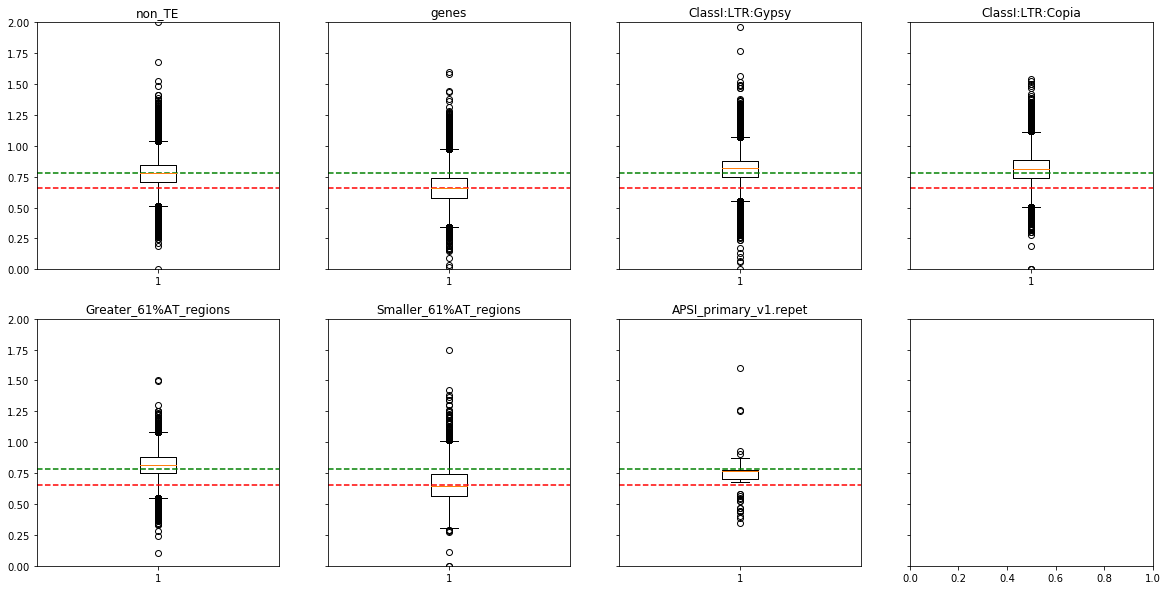

In [25]:
#'TpA/ApT': dicount_dict_S increases due to RIP
fig, ax = plt.subplots(rows, col, figsize = (20, 10), sharey=True)
gene_mean = np.median(dicount_dict_S['genes']\
                      [(dicount_dict_length['genes'] > cutoff)&(~np.isnan(dicount_dict_S['genes']))][:-1])
non_TE_mean = np.median(dicount_dict_S['non_TE']\
                      [(dicount_dict_length['non_TE'] > cutoff)&(~np.isnan(dicount_dict_S['non_TE']))][:-1])
for n, key in enumerate(list_of_interest):
    r = n // col
    c = n % col
    ax[r,c].boxplot(dicount_dict_S[key][(dicount_dict_length[key] > cutoff)&(~np.isnan(dicount_dict_S[key]))][:-1])
    ax[r,c].set_title(key)
    ax[r,c].set_ylim(0,2)
    ax[r,c].axhline(gene_mean, c='r', ls='--')
    ax[r,c].axhline(non_TE_mean, c='g', ls='--')
    #ax[]

In [26]:
#maybe do the rip analysis by family instead
#maybe consider doing reverse complements as well

In [27]:
#now pull in the control files
GENOME_NAME_DICT = {}
GENOME_NAME_DICT['Blumeria graminis f. sp. hordei'] = 'Blumeria_graminis_f.sp.hordei_DH14__GCA_900239735.1_BGH_DH14_v4_genomic'
GENOME_NAME_DICT['Marssonina brunnea'] = 'Marssonina_brunnea_GCF_000298775.1_ASM29877v1_genomic'
GENOME_NAME_DICT['Rhynchosporium commune'] = 'Rhynchosporium_commune__GCA_900074885.1_version_1_genomic'
GENOME_NAME_DICT['Parauncinula polyspora'] = 'parauncinula_polyspora.scaffolds'

In [28]:
#first pull in the genome files
#then pull in the gff files and subset them
GENOME_FN_DICT = {}
for key, value in GENOME_NAME_DICT.items():
    if key != 'Parauncinula polyspora':
        GENOME_FN_DICT[key] = os.path.join(CONTROL_FOLDER, value + '.fna')
    else:
        GENOME_FN_DICT[key] = os.path.join(CONTROL_FOLDER, value + '.fa')

In [29]:
GFF_FN_DICT = {}
for key, value in GENOME_FN_DICT.items():
    GFF_FN_DICT[key] = value + '.out.gff'

In [30]:
SUB_GFF_FN_DICT = {}
selection = ['Tad1', 'Gypsy', 'Copia']
for key, value in GFF_FN_DICT.items():
    SUB_GFF_FN_DICT[key] = RM_subset(value, selection)

In [31]:
###Generate the non-TE GFF/bed which requires 
### the genome file as well
selection.append('non_TE')
for key, value in SUB_GFF_FN_DICT.items():
    tmp_fn = reverse_bed(GENOME_FN_DICT[key], GFF_FN_DICT[key])
    #print(value.append(tmp_fn))
    SUB_GFF_FN_DICT[key].append(tmp_fn)

In [32]:
#next steps is to generate the whole counting
#and result dicts followed by plotting.
SUB_GFF_FN_DICT

{'Blumeria graminis f. sp. hordei': ['../../AT_analysis/control_samples/Blumeria_graminis_f.sp.hordei_DH14__GCA_900239735.1_BGH_DH14_v4_genomic.fna.out.Tad1.gff',
  '../../AT_analysis/control_samples/Blumeria_graminis_f.sp.hordei_DH14__GCA_900239735.1_BGH_DH14_v4_genomic.fna.out.Gypsy.gff',
  '../../AT_analysis/control_samples/Blumeria_graminis_f.sp.hordei_DH14__GCA_900239735.1_BGH_DH14_v4_genomic.fna.out.Copia.gff',
  '../../AT_analysis/control_samples/Blumeria_graminis_f.sp.hordei_DH14__GCA_900239735.1_BGH_DH14_v4_genomic.fna.out.reverse.nr.bed'],
 'Marssonina brunnea': ['../../AT_analysis/control_samples/Marssonina_brunnea_GCF_000298775.1_ASM29877v1_genomic.fna.out.Tad1.gff',
  '../../AT_analysis/control_samples/Marssonina_brunnea_GCF_000298775.1_ASM29877v1_genomic.fna.out.Gypsy.gff',
  '../../AT_analysis/control_samples/Marssonina_brunnea_GCF_000298775.1_ASM29877v1_genomic.fna.out.Copia.gff',
  '../../AT_analysis/control_samples/Marssonina_brunnea_GCF_000298775.1_ASM29877v1_genomic

In [33]:
#get the fa and fac count done.
SUB_FA_FN_DICT = {}
SUB_FAC_FN_DICT = {}
for key, bed_files in SUB_GFF_FN_DICT.items():
    tmp_fa_list = []
    tmp_fac_list = []
    for tmp_bed_file in bed_files:
        #get the fa files from the bedfiles
        ending = os.path.basename(tmp_bed_file).split('.')[-1]
        tmp_fa_out_fn = os.path.join(TMP_FOLDER, os.path.basename(tmp_bed_file)\
                              .replace(ending, 'fa'))
        tmp_bed = BedTool(tmp_bed_file)
        tmp_bed.sequence(fi=GENOME_FN_DICT[key]).save_seqs(tmp_fa_out_fn)
        tmp_fa_list.append(tmp_fa_out_fn)
        #now do the fac count
        tmp_fac_out_fn = tmp_fa_out_fn.replace('.fa' , '.fac')
        facount(tmp_fa_out_fn, tmp_fac_out_fn)
        tmp_fac_list.append(tmp_fac_out_fn)
    SUB_FA_FN_DICT[key] = tmp_fa_list
    SUB_FAC_FN_DICT[key] = tmp_fac_list    


In [34]:
##rename things to be name compatible with the upstream part ['Tad1', 'Gypsy', 'Copia', 'non_TE']
new_selection = ['Tad1', 'ClassI:LTR:Gypsy','ClassI:LTR:Copia', 'non_TE']

In [35]:
SUB_S_DICT = {}
SUB_L_DICT = {}
SUB_length_DICT = {}

for key, fac_list in SUB_FAC_FN_DICT.items():
    #now get the different dictionaries
    #'TpA/ApT'
    tmp_S = {}
    #'CpA + TpG/ApC + GpT'
    tmp_L = {}
    #length
    tmp_length = {}
    for name, tmp_fac_fn in zip(new_selection, fac_list):
        print(name)
        
        tmp_df = do_RIP_call(tmp_fac_fn)
        #selection would be the keys
        tmp_S[name] = tmp_df['TpA/ApT'].values
        tmp_L[name] = tmp_df['CpA + TpG/ApC + GpT'].values
        tmp_length[name] = tmp_df['len'].values
    SUB_S_DICT[key] = tmp_S
    SUB_L_DICT[key] = tmp_L
    SUB_length_DICT[key] = tmp_length

Tad1
ClassI:LTR:Gypsy
ClassI:LTR:Copia
non_TE
Tad1
ClassI:LTR:Gypsy
ClassI:LTR:Copia
non_TE
Tad1
ClassI:LTR:Gypsy
ClassI:LTR:Copia
non_TE
Tad1
ClassI:LTR:Gypsy
ClassI:LTR:Copia
non_TE


In [36]:
print('#TpA/ApT')
for key, tmp_dict in SUB_S_DICT.items():
    print(F'\n\n#####{key}####')
    for name in new_selection[1:]:
        tmp_x = np.median(tmp_dict[name][(SUB_length_DICT[key][name] > 500)&(~np.isnan(tmp_dict[name]))][:-1])
        print(F'This is the median for {name}: {tmp_x}')


#TpA/ApT


#####Blumeria graminis f. sp. hordei####
This is the median for ClassI:LTR:Gypsy: 0.7605847204438754
This is the median for ClassI:LTR:Copia: 0.7240461060410952
This is the median for non_TE: 0.796875


#####Marssonina brunnea####
This is the median for ClassI:LTR:Gypsy: 1.4615384615384615
This is the median for ClassI:LTR:Copia: 1.3785831285831285
This is the median for non_TE: 1.0510204081632653


#####Rhynchosporium commune####
This is the median for ClassI:LTR:Gypsy: 1.5909090909090908
This is the median for ClassI:LTR:Copia: 1.6187845303867403
This is the median for non_TE: 1.2709826318260053


#####Parauncinula polyspora####
This is the median for ClassI:LTR:Gypsy: 0.6824463118580766
This is the median for ClassI:LTR:Copia: 0.7115384615384616
This is the median for non_TE: 0.7814328485885372


In [37]:
print('CpA + TpG/ApC + GpT')
for key, tmp_dict in SUB_L_DICT.items():
    print(F'\n\n#####{key}####')
    for name in new_selection[1:]:
        tmp_x = np.median(tmp_dict[name][(SUB_length_DICT[key][name] > 500)&(~np.isnan(tmp_dict[name]))][:-1])
        print(F'This is the median for {name}: {tmp_x}')


CpA + TpG/ApC + GpT


#####Blumeria graminis f. sp. hordei####
This is the median for ClassI:LTR:Gypsy: 1.2605126218824203
This is the median for ClassI:LTR:Copia: 1.342293385619198
This is the median for non_TE: 1.2555380301437085


#####Marssonina brunnea####
This is the median for ClassI:LTR:Gypsy: 0.4714285714285714
This is the median for ClassI:LTR:Copia: 0.6587346024636058
This is the median for non_TE: 0.9560439560439561


#####Rhynchosporium commune####
This is the median for ClassI:LTR:Gypsy: 0.15384615384615385
This is the median for ClassI:LTR:Copia: 0.2604166666666667
This is the median for non_TE: 0.781146565539565


#####Parauncinula polyspora####
This is the median for ClassI:LTR:Gypsy: 1.209461580723648
This is the median for ClassI:LTR:Copia: 1.34375
This is the median for non_TE: 1.228617142097078


In [38]:
#now the plotting
cutoff = 500
col = 5
rows = 5 // col
if 5 % col > 0:
    rows +=1
print(rows)

1


In [39]:
cutoff = 0


In [40]:
ordered_keys = [ 'Marssonina brunnea', 'Rhynchosporium commune', 'Parauncinula polyspora', 'Blumeria graminis f. sp. hordei']

#TpA/ApT


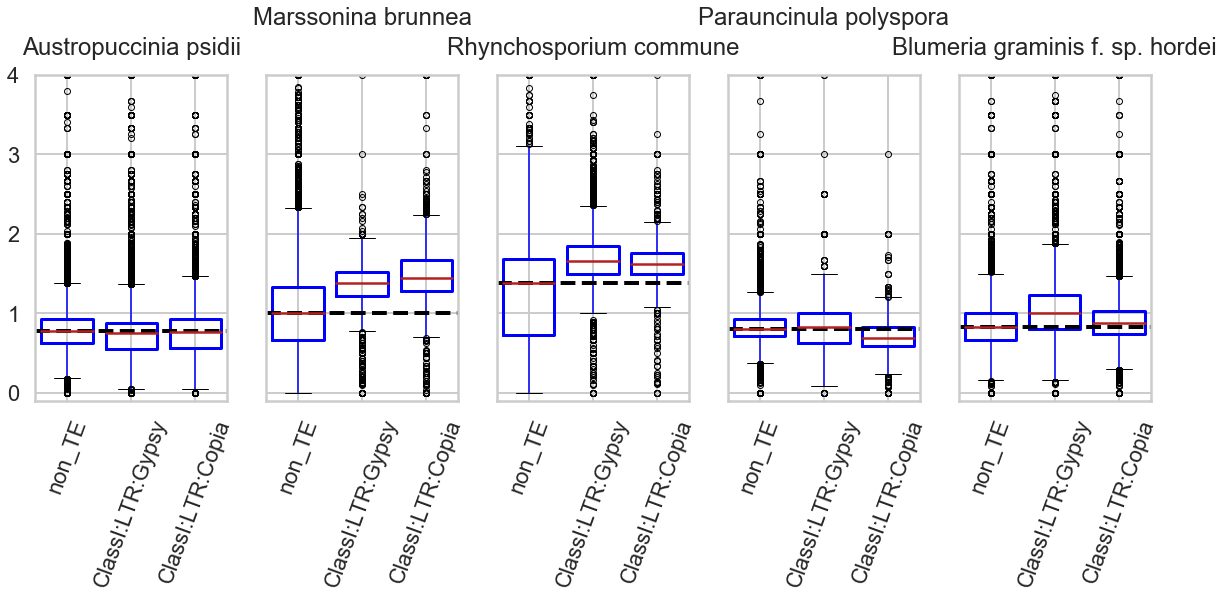

In [41]:
print('#TpA/ApT')
sns.set_style("whitegrid")
sns.set_context("poster")
boxprops = dict(linewidth=3, color='b')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
whiskerprops = dict(linewidth=1.5, color='b')

fig, ax = plt.subplots(rows, col, figsize = (20, 6), sharey=True)
new_selection = ['non_TE','ClassI:LTR:Gypsy','ClassI:LTR:Copia']

#do AP first
non_TE_mean = np.median(dicount_dict_S['non_TE']\
                      [(dicount_dict_length['non_TE'] > cutoff)&(~np.isnan(dicount_dict_S['non_TE']))][:-1])
tmp_data = []
for n, key in enumerate(new_selection):
    tmp_val = dicount_dict_S[key][(dicount_dict_length[key] > cutoff)&(~np.isnan(dicount_dict_S[key]))][:-1]
    tmp_data.append(tmp_val)

tmp_box = ax[0].boxplot(tmp_data, vert=True,  # vertical box alignment
                         patch_artist=False,
             widths=0.8,
            boxprops=boxprops,
            medianprops=medianprops,
            whiskerprops = whiskerprops)
ax[0].axhline(non_TE_mean, c='black', ls='--', linewidth = 4)
ax[0].set_title('Austropuccinia psidii', pad = 20)
ax[0].set_xticklabels(new_selection, rotation = 70)
ax[0].set_ylim(-0.1, 4)
#tmp_box = 

count = 1

for key in ordered_keys:
    tmp_non_TE_mean = np.median(SUB_S_DICT[key]['non_TE'][(SUB_length_DICT[key]['non_TE'] > cutoff)\
                                               &(~np.isnan(SUB_S_DICT[key]['non_TE']))][:-1])
    tmp_data = []
    for name in new_selection:
        tmp_val  = SUB_S_DICT[key][name][(SUB_length_DICT[key][name] > cutoff)\
                                               &(~np.isnan(SUB_S_DICT[key][name]))][:-1]
        tmp_data.append(tmp_val)
    ax[count].boxplot(tmp_data, vert=True,  # vertical box alignment
                         patch_artist=False,
             widths=0.8,
            boxprops=boxprops,
            medianprops=medianprops,
            whiskerprops = whiskerprops)
    

    ax[count].axhline(tmp_non_TE_mean, c='black', ls='--', linewidth = 4)
    ax[count].set_title(key, pad= (20 + 30 * (count%2)))
    ax[count].set_xticklabels(new_selection, rotation = 70)
    count += 1
out_fn = os.path.join(OUT_FOLDER_FIG, 'TpA_etal_ratio.png')
#fig.tight_layout()
fig.savefig(out_fn, dpi=600, bbox_inches = "tight")

CpA + TpG/ApC + GpT


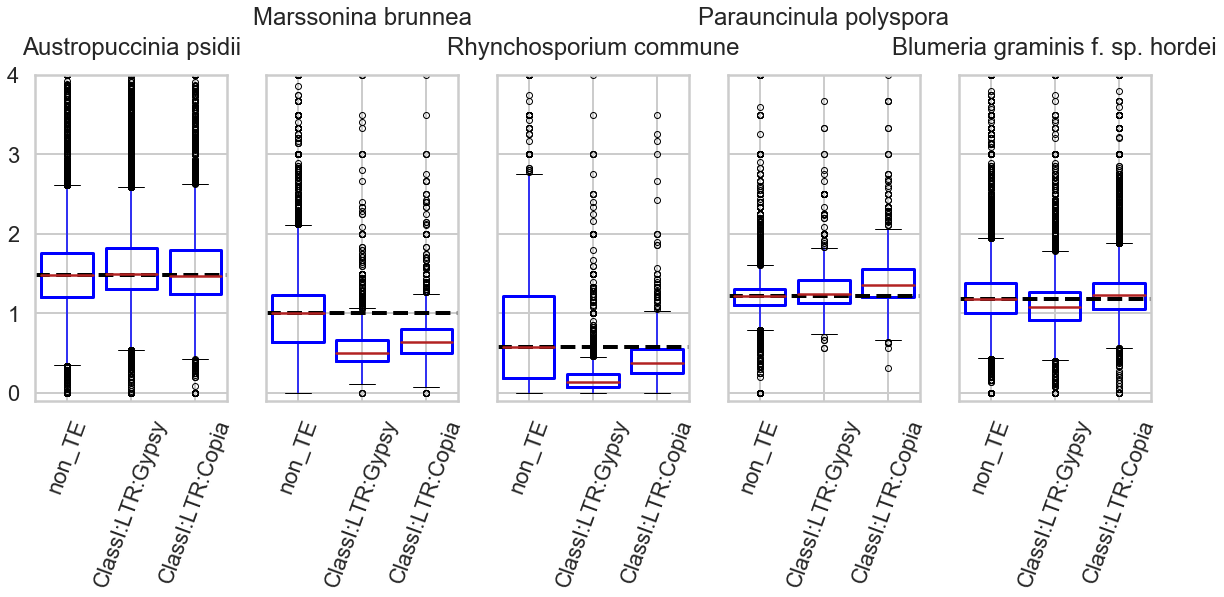

In [42]:
print('CpA + TpG/ApC + GpT')
sns.set_style("whitegrid")
sns.set_context("poster")
boxprops = dict(linewidth=3, color='b')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
whiskerprops = dict(linewidth=1.5, color='b')

fig, ax = plt.subplots(rows, col, figsize = (20, 6), sharey=True)
new_selection = ['non_TE','ClassI:LTR:Gypsy','ClassI:LTR:Copia']

#do AP first
non_TE_mean = np.median(dicount_dict_L['non_TE']\
                      [(dicount_dict_length['non_TE'] > cutoff)&(~np.isnan(dicount_dict_L['non_TE']))][:-1])
tmp_data = []
for n, key in enumerate(new_selection):
    tmp_val = dicount_dict_L[key][(dicount_dict_length[key] > cutoff)&(~np.isnan(dicount_dict_L[key]))][:-1]
    tmp_data.append(tmp_val)

tmp_box = ax[0].boxplot(tmp_data, vert=True,  # vertical box alignment
                         patch_artist=False,
             widths=0.8,
            boxprops=boxprops,
            medianprops=medianprops,
            whiskerprops = whiskerprops)
ax[0].axhline(non_TE_mean, c='black', ls='--', linewidth = 4)
ax[0].set_title('Austropuccinia psidii', pad = 20)
ax[0].set_xticklabels(new_selection, rotation = 70)
ax[0].set_ylim(-0.1, 4)
#tmp_box = 

count = 1

for key in ordered_keys:
    tmp_non_TE_mean = np.median(SUB_L_DICT[key]['non_TE'][(SUB_length_DICT[key]['non_TE'] > cutoff)\
                                               &(~np.isnan(SUB_L_DICT[key]['non_TE']))][:-1])
    tmp_data = []
    for name in new_selection:
        tmp_val  = SUB_L_DICT[key][name][(SUB_length_DICT[key][name] > cutoff)\
                                               &(~np.isnan(SUB_L_DICT[key][name]))][:-1]
        tmp_data.append(tmp_val)
    ax[count].boxplot(tmp_data, vert=True,  # vertical box alignment
                         patch_artist=False,
             widths=0.8,
            boxprops=boxprops,
            medianprops=medianprops,
            whiskerprops = whiskerprops)
    

    ax[count].axhline(tmp_non_TE_mean, c='black', ls='--', linewidth = 4)
    ax[count].set_title(key, pad= (20 + 30 * (count%2)))
    ax[count].set_xticklabels(new_selection, rotation = 70)
    count += 1
out_fn = os.path.join(OUT_FOLDER_FIG, 'CpA_etal_ratio.png')
fig.savefig(out_fn, dpi=600, bbox_inches = "tight")

### Look very briefly at the CG vs other frequency. Should be done according to 'age' groups

In [43]:
count_df_dict.keys()

dict_keys(['ClassI:?:?', 'ClassI:SINE:5S', 'ClassI:LTR:Gypsy', 'ClassI:LTR:?', 'ClassI:DIRS:DIRS', 'ClassI:LINE:Jockey', 'ClassI:LINE:L1', 'ClassI:LARD:?', 'ClassI:LTR:Retrovirus', 'ClassI:DIRS:?', 'ClassI:LINE:RTE', 'ClassI:LINE:R2', 'ClassI:LTR:Bel-Pao', 'ClassI:LINE:I', 'ClassI:LTR:Copia', 'ClassI:PLE:Penelope', 'ClassI:TRIM:?', 'ClassI:SINE:?', 'ClassI:LTR:ERV', 'ClassI:LINE:?', 'ClassII:TIR:CACTA', 'ClassII:TIR:PIF-Harbinger', 'ClassII:?:Kolobok', 'ClassII:Helitron:?', 'ClassII:TIR:P', 'ClassII:MITE:?', 'ClassII:TIR:PiggyBac', 'ClassII:TIR:hAT', 'ClassII:TIR:Transib', 'ClassII:TIR:MuDR', 'ClassII:TIR:Tc1-Mariner', 'ClassII:Crypton:Crypton', 'ClassII:Maverick:Maverick', 'ClassII:?:Ginger2_TDD', 'ClassII:Helitron:Helitron', 'ClassII:?:Ginger1', 'ClassII:TIR:?', 'ClassII:Maverick:?', 'ClassII:?:?', 'ClassII:?:Novosib', 'ClassII:?:Sola', 'non_TE', 'genes', 'Greater_61%AT_regions', 'Smaller_61%AT_regions', 'APSI_primary_v1.repet'])

0.23927871789882335


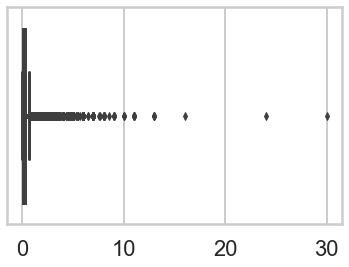

In [44]:
cos = 'non_TE'
mean = np.mean(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos]['TA'] + count_df_dict[cos]['AT'])).replace([-np.inf, np.inf], np.nan).dropna())
print(mean)
sns.boxplot(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos]['TA'] + count_df_dict[cos]['AT'])).replace([-np.inf, np.inf], np.nan).dropna())

In [45]:
count_df_dict[cos]

,seqID,len,A,C,G,T,N,cpg,AA,AC,...,GA,GC,GG,GT,TA,TC,TG,TT,TpA/ApT,CpA + TpG/ApC + GpT
0,ApsiP_S0001:0-51,51,17,26,0,8,0,0,8,9,...,0,0,0,0,8,0,0,0,NaN,0.000000
1,ApsiP_S0001:1493-7808,6315,2111,811,932,2461,0,30,888,210,...,383,113,167,269,512,370,456,1123,0.698499,1.634656
2,ApsiP_S0001:8881-9057,176,79,20,24,53,0,0,41,8,...,13,0,5,6,16,7,9,20,0.800000,1.285714
3,ApsiP_S0001:11512-11516,4,1,1,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,NaN,NaN
4,ApsiP_S0001:14844-15783,939,304,180,166,289,0,10,108,58,...,47,28,38,53,67,56,57,108,0.870130,1.243243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282736,ApsiP_S0054:1497-1501,4,2,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0.000000,NaN
282737,ApsiP_S0059:1267-1271,4,0,0,3,1,0,0,0,0,...,0,0,2,0,0,0,1,0,NaN,NaN
282738,ApsiP_S0060:1181-1185,4,2,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,NaN,1.000000
282739,ApsiP_S0062:0-4,4,1,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN


0.33201526226254774


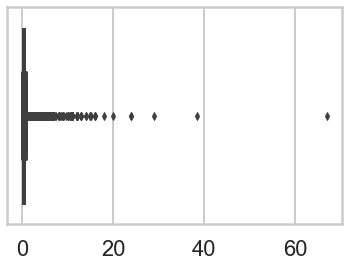

In [46]:
cos = 'ClassI:LTR:Copia'
mean = np.mean(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos]['TA'] + count_df_dict[cos]['AT'])).replace([-np.inf, np.inf], np.nan).dropna())
print(mean)
sns.boxplot(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos]['TA'] + count_df_dict[cos]['AT'])).replace([-np.inf, np.inf], np.nan).dropna())

0.5562718032980555


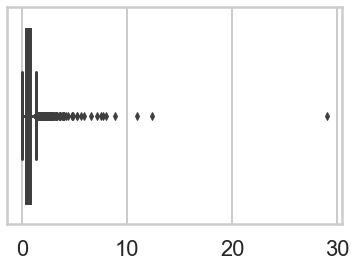

In [47]:
cos = 'genes'
mean = np.mean(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos]['TA'] + count_df_dict[cos]['AT'])).replace([-np.inf, np.inf], np.nan).dropna())
print(mean)
sns.boxplot(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos]['TA'] + count_df_dict[cos]['AT'])).replace([-np.inf, np.inf], np.nan).dropna())

0.3735374915191754


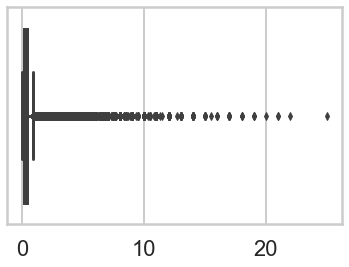

In [48]:
cos = 'ClassI:LTR:Gypsy'
mean = np.mean(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos]['TA'] + count_df_dict[cos]['AT'])).replace([-np.inf, np.inf], np.nan).dropna())
print(mean)
sns.boxplot(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos]['TA'] + count_df_dict[cos]['AT'])).replace([-np.inf, np.inf], np.nan).dropna())

In [49]:
cos = 'ClassI:LTR:Gypsy'
np.mean(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos].len).replace([-np.inf, np.inf], np.nan).dropna()))


0.040970263352668165

In [50]:
cos = 'genes'
np.mean(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos].len).replace([-np.inf, np.inf], np.nan).dropna()))

0.06790707433830108

In [51]:
cos = 'ClassI:LTR:Copia'
np.mean(((count_df_dict[cos]['CG'] + count_df_dict[cos]['GC'])\
/(count_df_dict[cos].len).replace([-np.inf, np.inf], np.nan).dropna()))

0.03680374177318594

In [52]:
#next would be to pull in the REPET_df with GC content per superfamily. This could then
#be used to subset the GFF and look at some features according to TE age
#could also look at CpG islands with the nanopolish add on tool.CpG might be easier for a start
#start with Gyspies and see if this works for them.

In [53]:
REPET_df = pd.read_csv('../../TE_analysis/MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.v2.tab', sep='\t')
REPET_gff_df = pd.read_csv(repet_gff_fn, header=None, sep='\t')

In [54]:
repet_gff_fn.replace('.gff3', '.tmp.gff3')

'../../TE_analysis/APSI_primary_v1.MR_P2A_300Mb.REPET.tmp.gff3'

In [72]:
#get all the dictionaries for all the repeat families
tmp_gff_fn = repet_gff_fn.replace('.gff3', '.tmp.gff3')
tmp_fa_fn = repet_gff_fn.replace('.gff3', '.tmp.fa')
tmp_fai_fn = repet_gff_fn.replace('.gff3', '.tmp.fai')
RIP_call_df = {}
for family in REPET_df.TE.unique():
    tmp_df = REPET_gff_df[REPET_gff_df[8].str.contains(family)]
    tmp_df.to_csv(tmp_gff_fn, header = None, index= None, sep='\t')
    pybedtools.BedTool(tmp_gff_fn).sort().merge().sequence(fi=repet_genome_fn, s=True, fo=tmp_fa_fn)
    facount(tmp_fa_fn, tmp_fai_fn)
    RIP_call_df[family] = do_RIP_call(tmp_fai_fn)
os.remove(tmp_gff_fn)
os.remove(tmp_fa_fn)
os.remove(tmp_fai_fn)

In [73]:
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'to_json'):
            return obj.to_json(orient='records')
        return json.JSONEncoder.default(self, obj)

In [ ]:
dict_ouf_fn = '../../TE_analysis/MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.v2.dict'
with open(dict_ouf_fn, 'w') as fp:
    json.dump(RIP_call_df, fp, cls=JSONEncoder)

In [74]:
#next is to bind some interesting features to the REPET_df for each family as lists
#e.g. length list and nucleotide lists
REPET_df['CpG/bp'] = REPET_df['TE'].apply(lambda x:\
                                          list((RIP_call_df[x]['CG'] + RIP_call_df[x]['GC'])\
                                          /RIP_call_df[x]['len']))

In [75]:
REPET_df['mean_CpG/bp'] = REPET_df['CpG/bp'].apply(lambda x: np.mean(x)) 

In [81]:
REPET_df['mean_CpG/kbp'] = REPET_df['CpG/bp'].apply(lambda x: np.mean(x)) *1000

In [ ]:
###save out dataframe again.


In [77]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 30}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

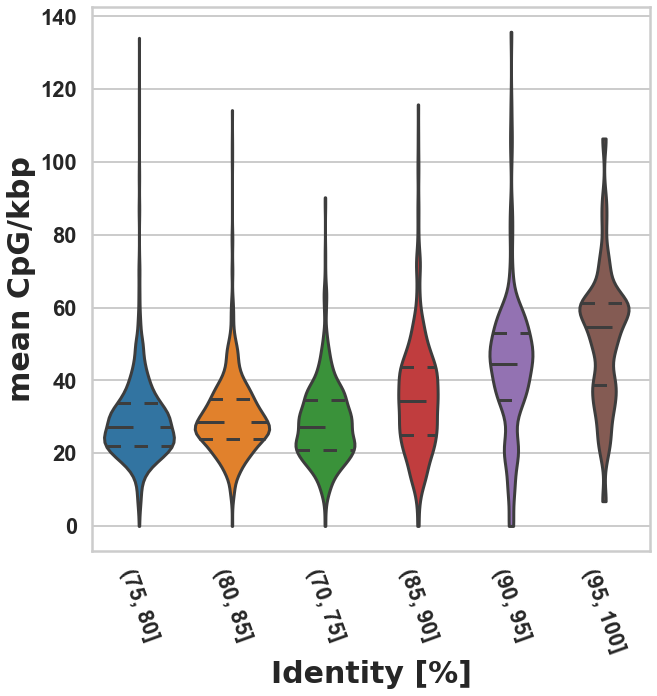

In [82]:
sns.set_style("whitegrid")
sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
sns.violinplot(x= 'GC_intervals', y='mean_CpG/kbp', data = REPET_df, ax=ax, cut=0, inner="quartile", bw=.2)
ax.set_xlabel('Identity [%]',  **font)
ax.set_ylabel('mean CpG/kbp', **font)
x = ax.get_xticks()
ax.set_xticklabels(ax.get_xticklabels(), rotation = -70)
out_fn = os.path.join(OUT_FOLDER_FIG, 'E_perID_vs_CpG_content.png')
fig.savefig(out_fn, dpi=600, bbox_inches = "tight")

In [101]:
out_fn

'../../figures/E_perID_vs_CpG_content.png'

In [88]:
import itertools

In [91]:
#maybe do some stats here with Kurtkurfalis https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html and one-to-one testing with corrections.
comparative_ints = REPET_df.GC_intervals.unique()[1:]
comparative_array = []
for x in comparative_ints:
    comparative_array.append(list(itertools.chain.from_iterable(REPET_df[REPET_df['GC_intervals']== x]['CpG/bp'].values)))

In [94]:
#do the overall 'ANOVA'
scipy.stats.kruskal(comparative_array[0],comparative_array[1], comparative_array[2], comparative_array[3], comparative_array[4], comparative_array[5])

KruskalResult(statistic=11603.655448875728, pvalue=0.0)

In [95]:
#do the individual tests
comparative_dict = {}
for x in comparative_ints:
    for y in comparative_ints:
        key = '%s_vs_%s' % (x, y)
        comparative_dict[key] = scipy.stats.mannwhitneyu(list(itertools.chain.from_iterable(REPET_df[REPET_df['GC_intervals']== x]['CpG/bp'].values)), \
                                                         list(itertools.chain.from_iterable(REPET_df[REPET_df['GC_intervals']== y]['CpG/bp'].values)))

In [96]:
comparative_dict

{'(75, 80]_vs_(75, 80]': MannwhitneyuResult(statistic=25136407328.0, pvalue=0.49999999539606355),
 '(75, 80]_vs_(80, 85]': MannwhitneyuResult(statistic=21537056249.5, pvalue=0.0),
 '(75, 80]_vs_(70, 75]': MannwhitneyuResult(statistic=7168594439.5, pvalue=4.614129291402841e-126),
 '(75, 80]_vs_(85, 90]': MannwhitneyuResult(statistic=2485164440.0, pvalue=0.0),
 '(75, 80]_vs_(90, 95]': MannwhitneyuResult(statistic=430618904.5, pvalue=0.0),
 '(75, 80]_vs_(95, 100]': MannwhitneyuResult(statistic=41220801.0, pvalue=1.3526512432211025e-137),
 '(80, 85]_vs_(75, 80]': MannwhitneyuResult(statistic=21537056249.5, pvalue=0.0),
 '(80, 85]_vs_(80, 85]': MannwhitneyuResult(statistic=22063652112.5, pvalue=0.49999999492428765),
 '(80, 85]_vs_(70, 75]': MannwhitneyuResult(statistic=6175774389.0, pvalue=0.0),
 '(80, 85]_vs_(85, 90]': MannwhitneyuResult(statistic=2534622558.5, pvalue=0.0),
 '(80, 85]_vs_(90, 95]': MannwhitneyuResult(statistic=433920015.5, pvalue=0.0),
 '(80, 85]_vs_(95, 100]': Mannwhitney

In [97]:
#do the multipletesting correction
cor_comparative_keys = []
cor_comparative_values = []

for key, value  in comparative_dict.items():
    cor_comparative_keys.append(key)
    cor_comparative_values.append(value[1])

cor_comparative_dict = dict(zip(cor_comparative_keys, statsmodels.stats.multitest.multipletests(cor_comparative_values)[1]))  

In [98]:
cor_comparative_dict

{'(75, 80]_vs_(75, 80]': 0.9843706876262387,
 '(75, 80]_vs_(80, 85]': 0.0,
 '(75, 80]_vs_(70, 75]': 0.0,
 '(75, 80]_vs_(85, 90]': 0.0,
 '(75, 80]_vs_(90, 95]': 0.0,
 '(75, 80]_vs_(95, 100]': 0.0,
 '(80, 85]_vs_(75, 80]': 0.0,
 '(80, 85]_vs_(80, 85]': 0.9843706876262387,
 '(80, 85]_vs_(70, 75]': 0.0,
 '(80, 85]_vs_(85, 90]': 0.0,
 '(80, 85]_vs_(90, 95]': 0.0,
 '(80, 85]_vs_(95, 100]': 0.0,
 '(70, 75]_vs_(75, 80]': 0.0,
 '(70, 75]_vs_(80, 85]': 0.0,
 '(70, 75]_vs_(70, 75]': 0.9843706876262387,
 '(70, 75]_vs_(85, 90]': 0.0,
 '(70, 75]_vs_(90, 95]': 0.0,
 '(70, 75]_vs_(95, 100]': 0.0,
 '(85, 90]_vs_(75, 80]': 0.0,
 '(85, 90]_vs_(80, 85]': 0.0,
 '(85, 90]_vs_(70, 75]': 0.0,
 '(85, 90]_vs_(85, 90]': 0.9843706876262387,
 '(85, 90]_vs_(90, 95]': 0.0,
 '(85, 90]_vs_(95, 100]': 0.0,
 '(90, 95]_vs_(75, 80]': 0.0,
 '(90, 95]_vs_(80, 85]': 0.0,
 '(90, 95]_vs_(70, 75]': 0.0,
 '(90, 95]_vs_(85, 90]': 0.0,
 '(90, 95]_vs_(90, 95]': 0.9843706876262387,
 '(90, 95]_vs_(95, 100]': 0.37917979979534444,
 '(9

### Statistic p-values are likely significant simply because of the large sample sizes.

ClassII:Helitron:?
ClassII:Maverick:?
ClassII:TIR:hAT
ClassII:TIR:PIF-Harbinger
ClassII:TIR:Tc1-Mariner
ClassII:TIR:CACTA
ClassII:TIR:?
ClassII:TIR:MuDR
False
ClassII:MITE:?
ClassII:?:?
noCat
ClassI:LINE:I
ClassI:LINE:?
ClassI:LTR:Gypsy
ClassI:LTR:?
ClassI:LTR:Copia
ClassI:LTR:Bel-Pao
ClassI:SINE:?
ClassI:LARD:?
ClassII:?:Novosib


/Users/benjamin/anaconda3/envs/RIP/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


ClassI:TRIM:?
ClassII:Crypton:Crypton
ClassII:Helitron:Helitron
ClassII:?:Ginger2_TDD
ClassI:?:?


ValueError: min() arg is an empty sequence

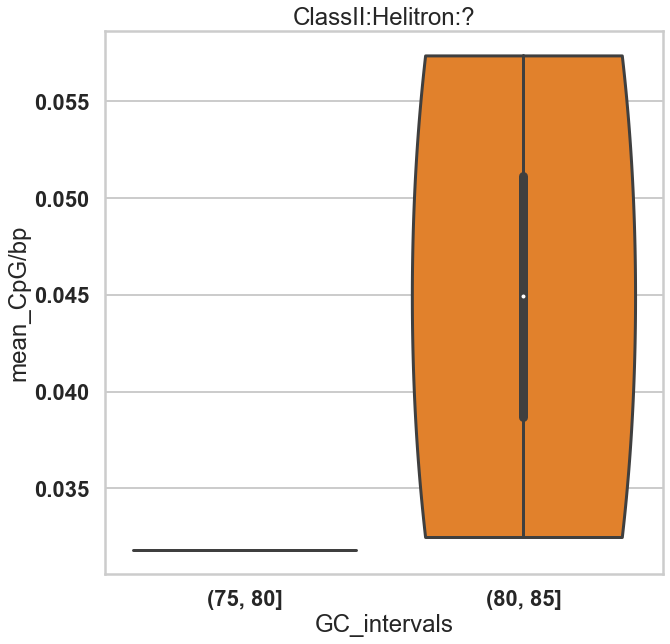

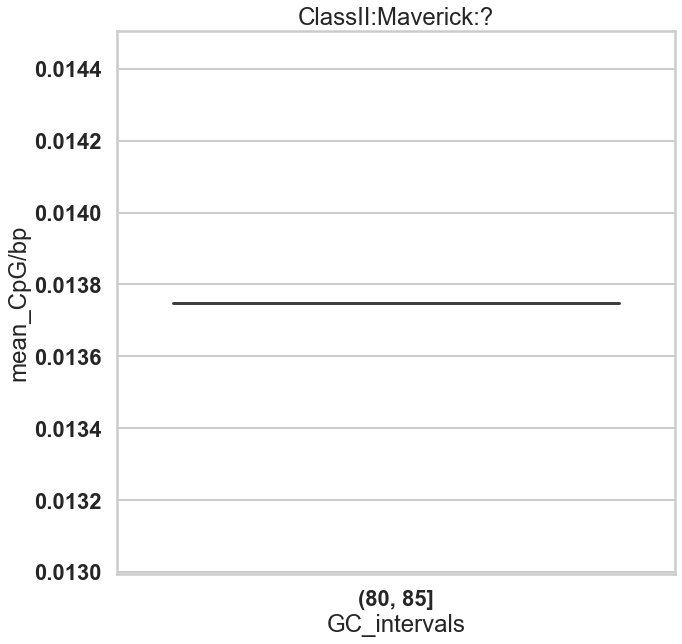

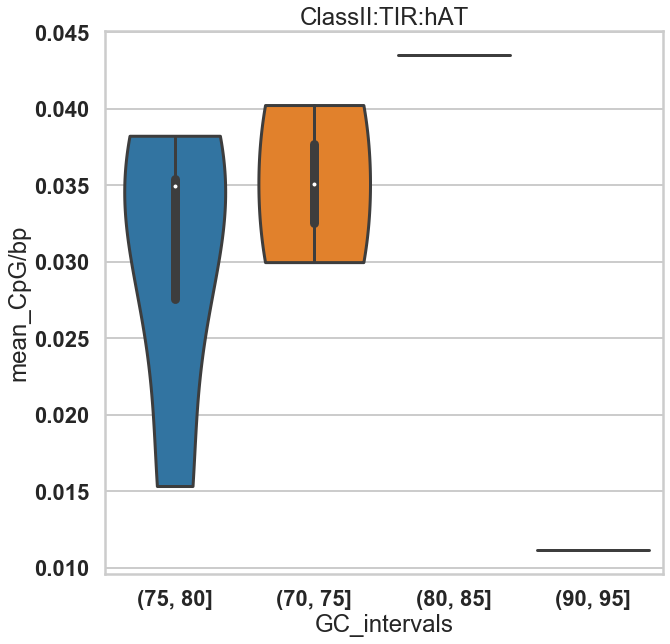

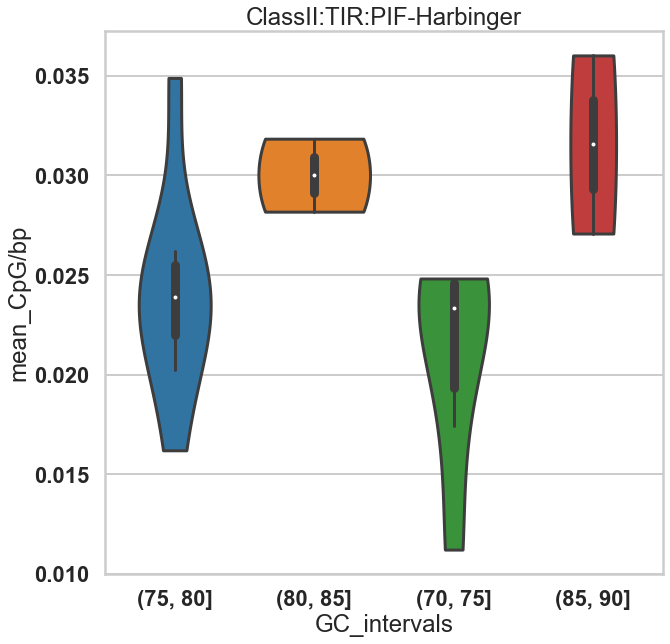

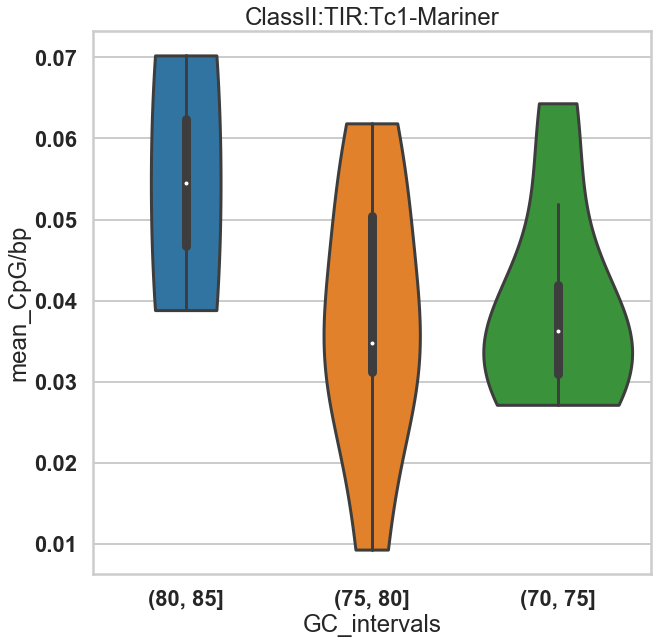

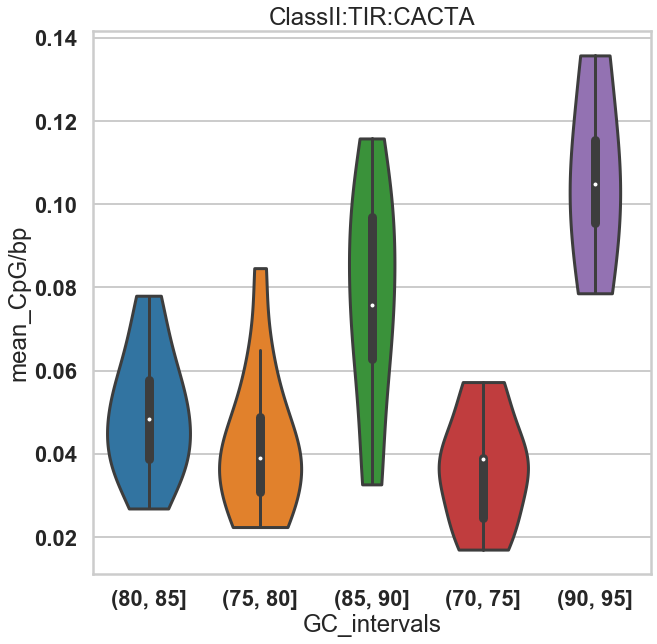

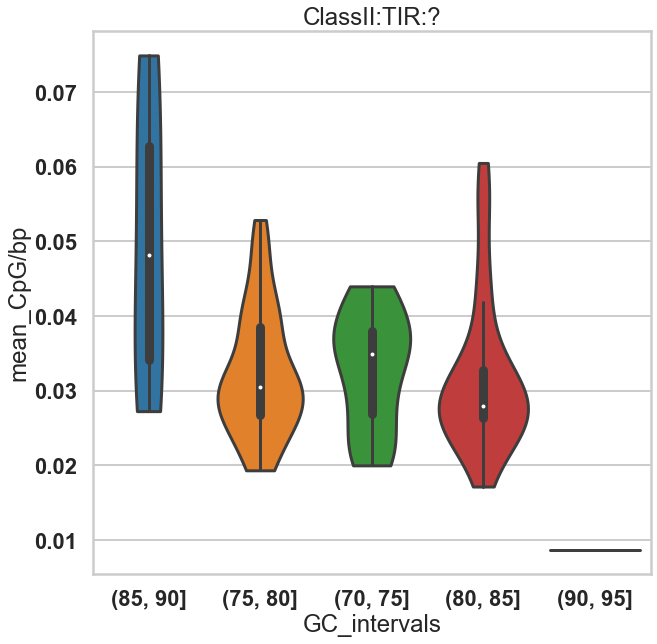

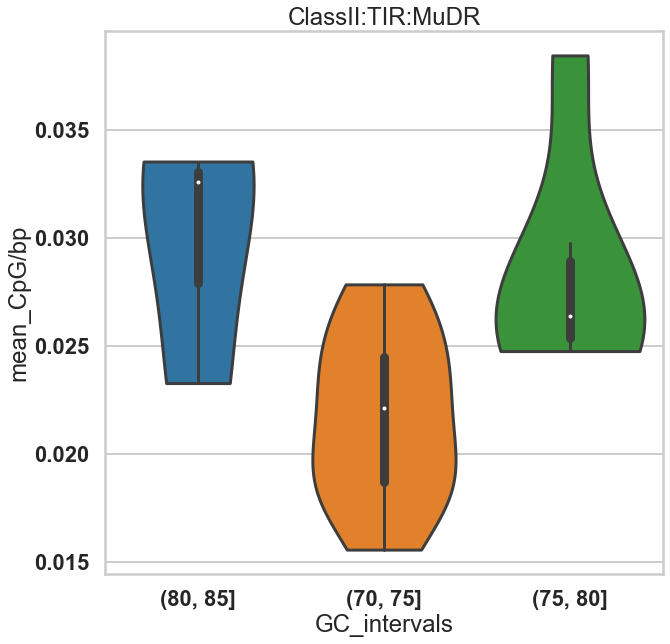

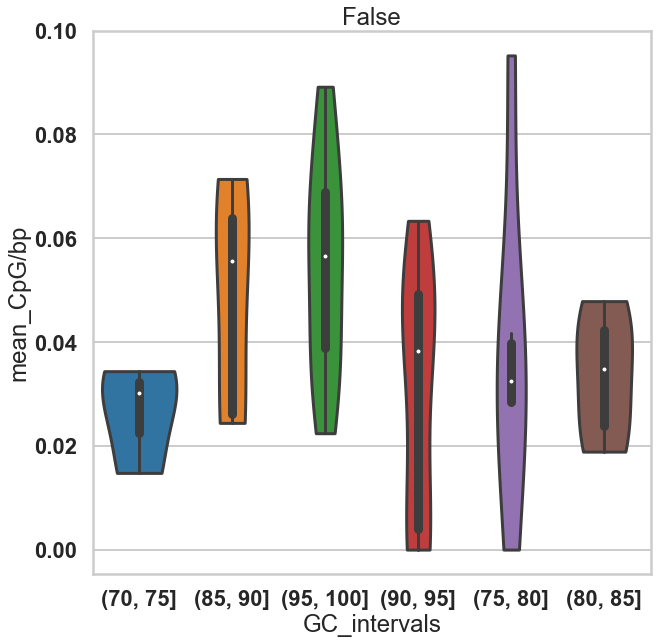

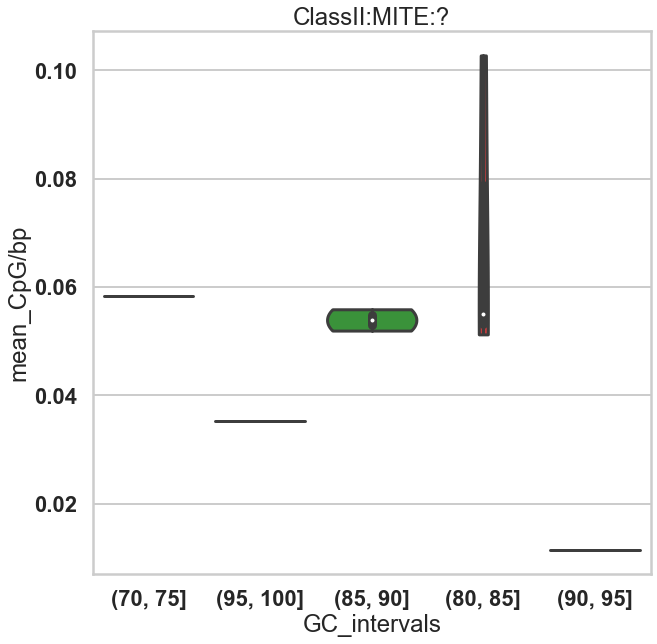

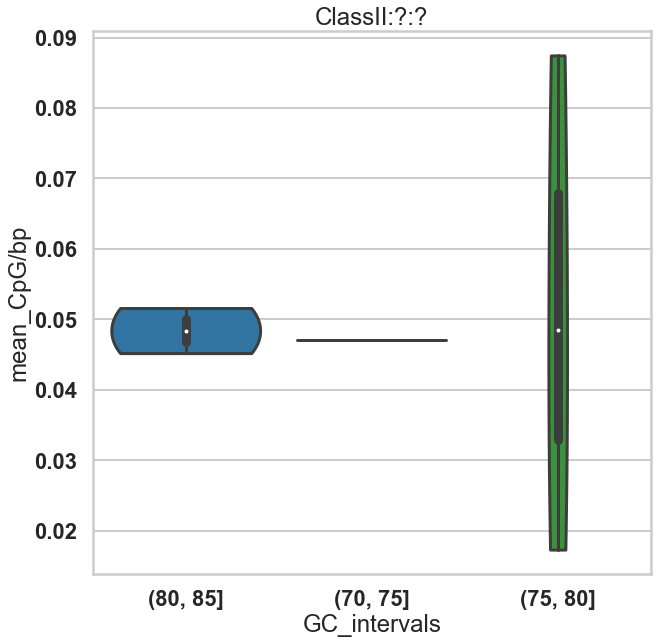

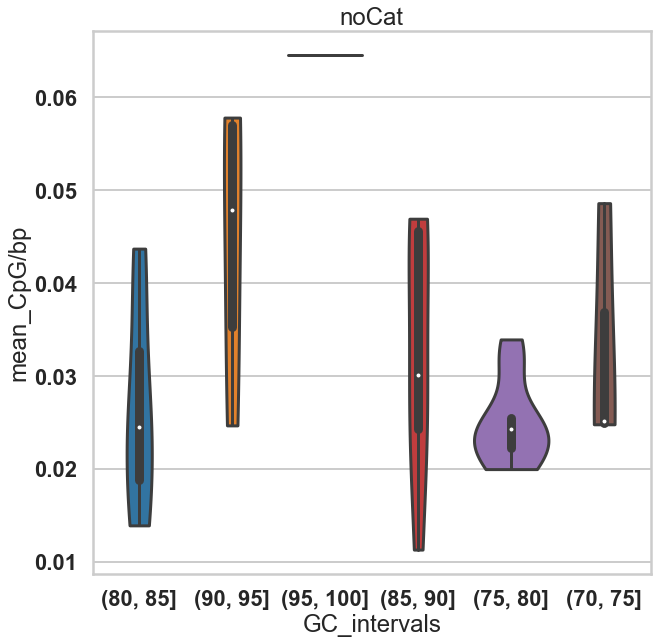

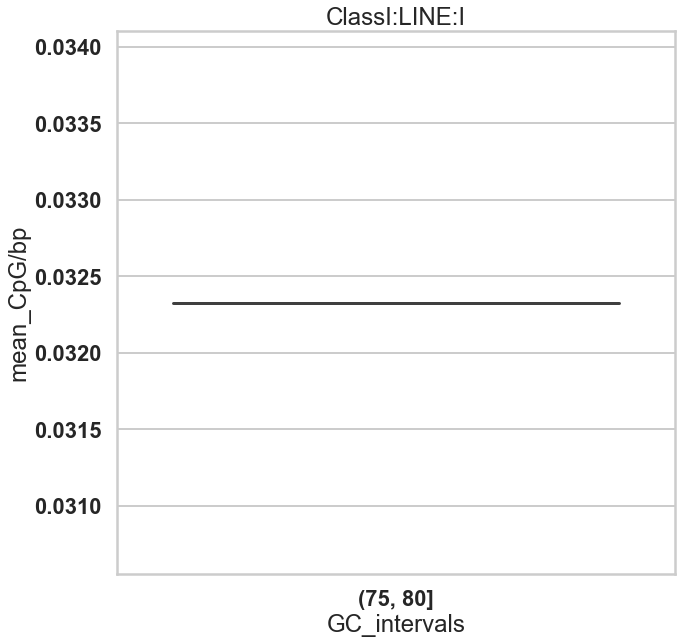

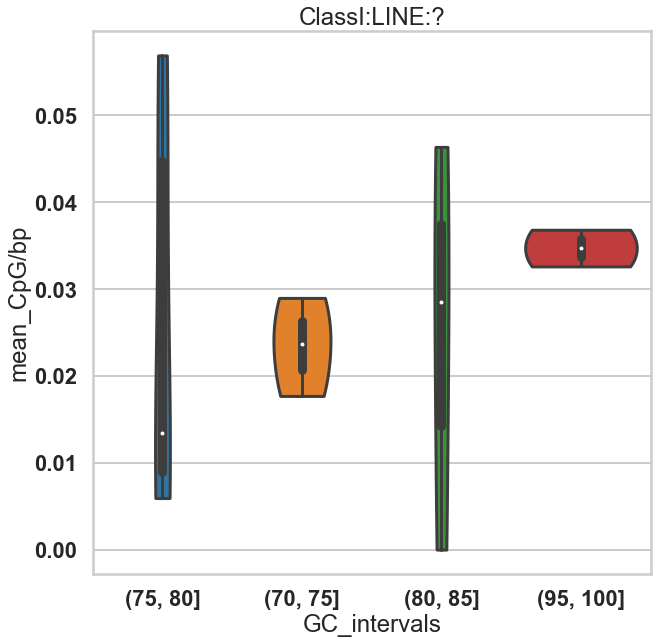

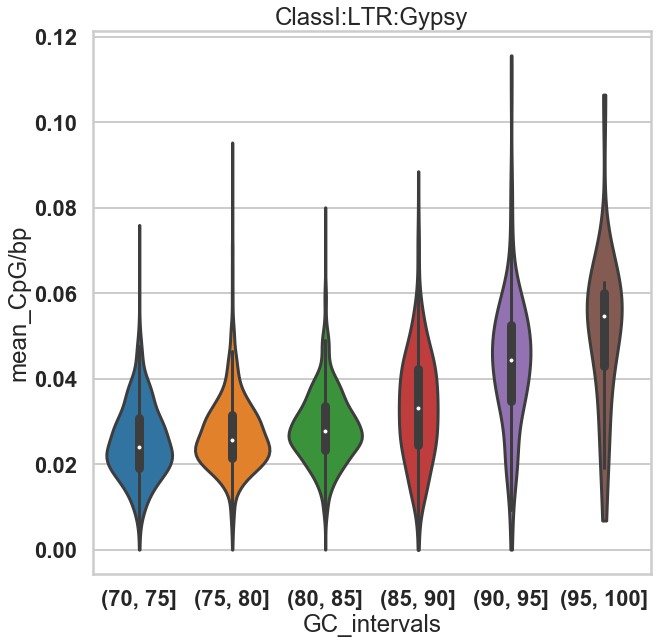

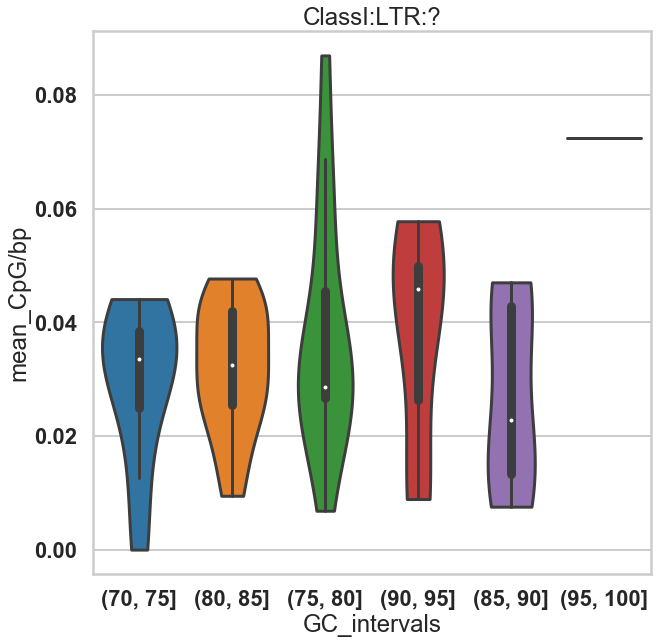

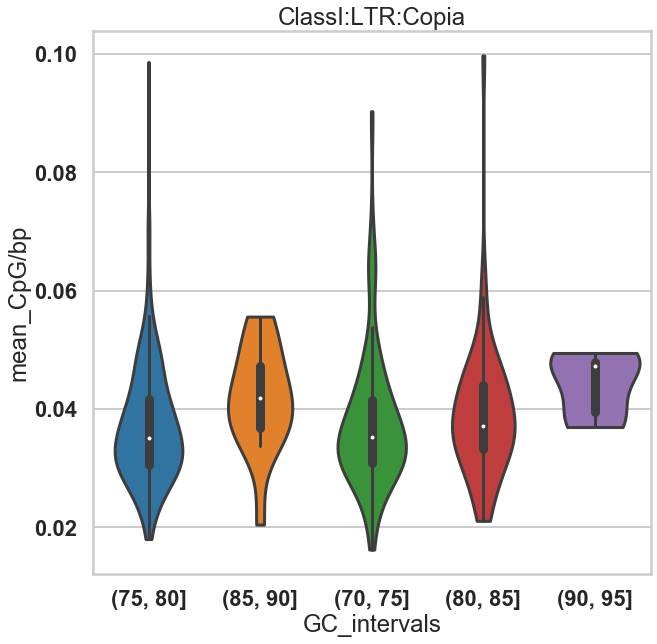

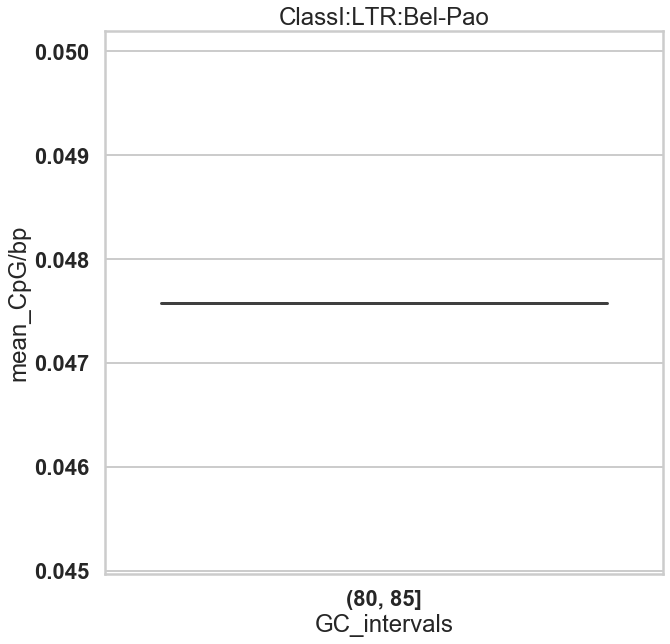

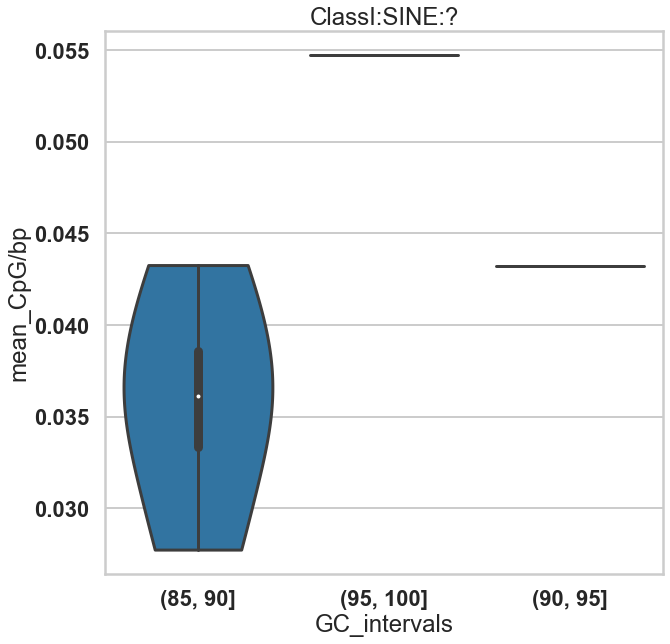

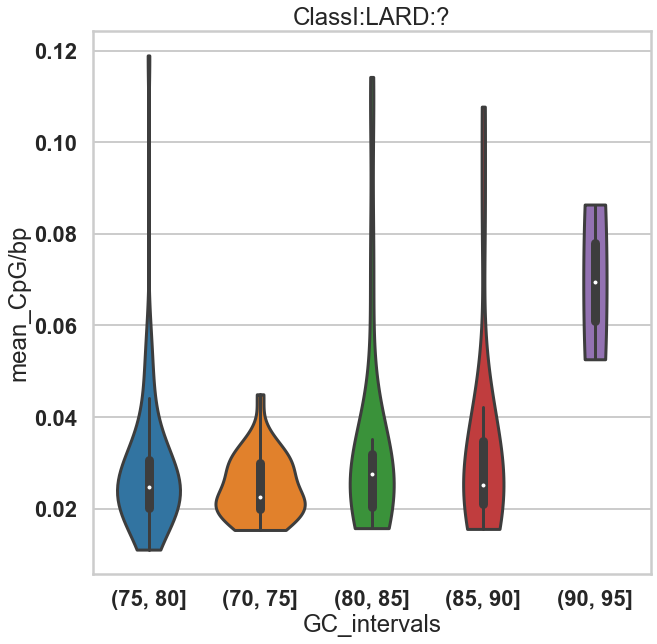

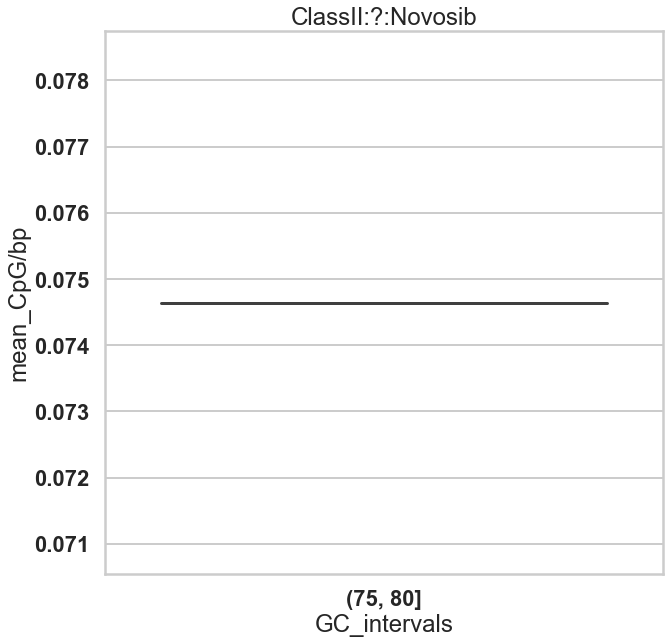

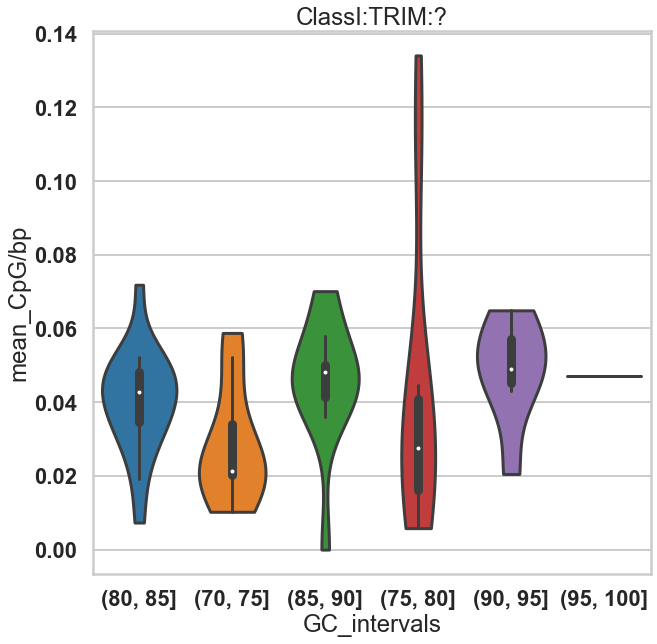

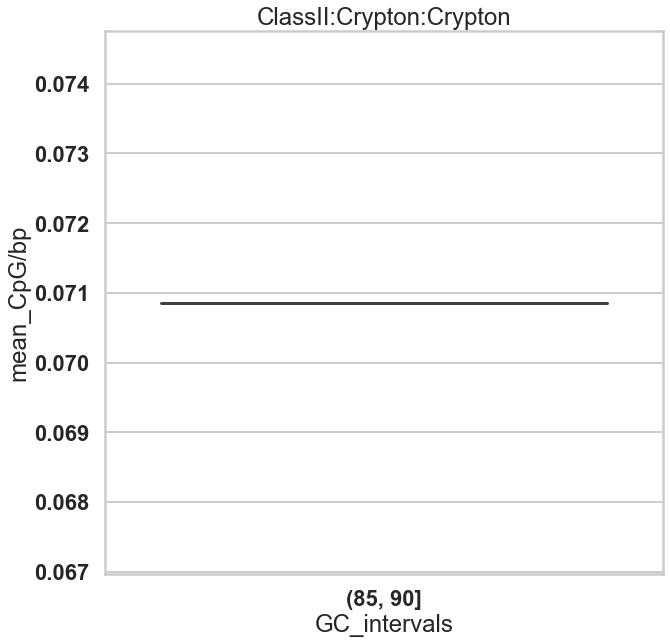

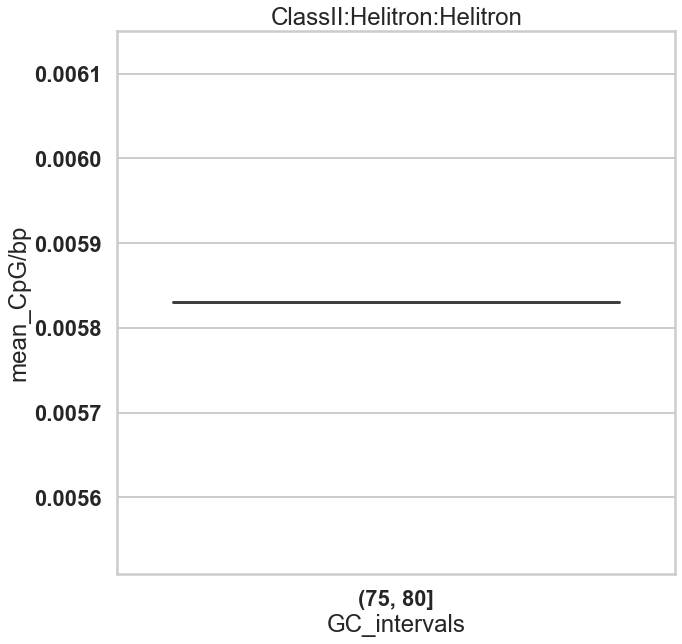

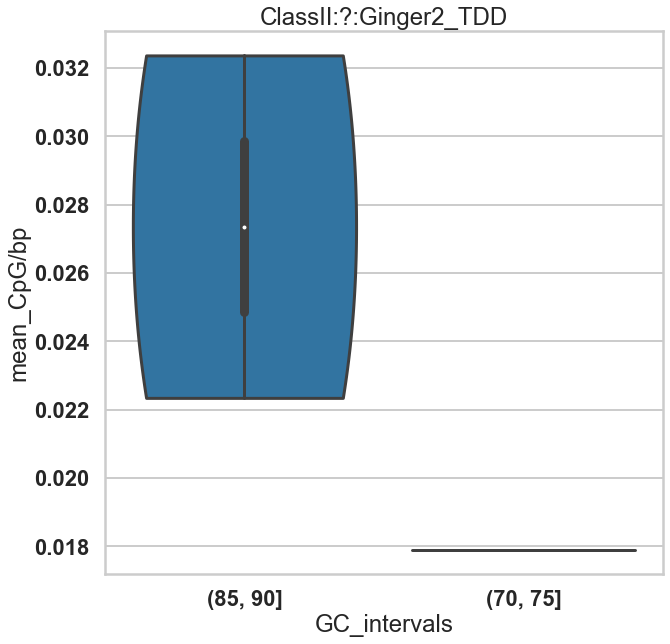

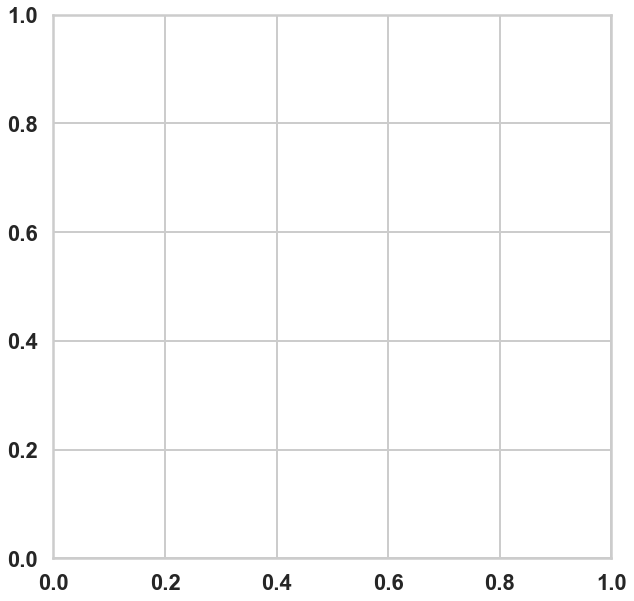

In [100]:
for cos in REPET_df.COS.unique():
    print(cos)
    fig, ax = plt.subplots(figsize = (10,10))
    sns.violinplot(x= 'GC_intervals', y='mean_CpG/bp', data = REPET_df[REPET_df.COS == cos], ax = ax,cut=0)
    ax.set_title(cos)

In [ ]:
RIP_call_df[family].columns

In [ ]:
!head {tmp_fa_fn}

In [ ]:
REPET_gff_df.head()

In [ ]:
REPET_gff_df[REPET_gff_df[8].str.contains('DHX-incomp-chim_Blc1018_MR_P2A_300Mb-L-B1021-Map1')]